In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataclasses import dataclass
from math import log, sqrt
from typing import Callable

import functorch
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
from pyro.distributions import Distribution
import torch
from torch import nn, optim, Tensor
from tqdm.auto import trange

from tightrope import NormalGFN, NormalDiffPriorGFN
from sde import VESDE

## GFlowNet

In [3]:
log_R = dist.Normal(torch.tensor([2.5]), torch.tensor([1.0])).to_event(1).log_prob
x_grid = torch.linspace(-4, 8, 500)
R_grid = log_R(x_grid[:, None]).exp()

In [4]:
class Net(nn.Module):
    def __init__(self, x_size, dt, hidden_dim=16, act_cls: nn.Module = nn.ELU):
        super().__init__()
        self.x_size = x_size
        self.dt = dt
        self.log_dt = log(dt)

        self.mlp = nn.Sequential(
            nn.Linear(x_size + 1, hidden_dim),
            act_cls(),
            nn.Linear(hidden_dim, hidden_dim),
            act_cls(),
            nn.Linear(hidden_dim, 2 * x_size),
        )

    def __call__(self, t, x_t):
        assert t.shape[0] == x_t.shape[0]
        assert x_t.ndim == 2

        t = t[:, None]
        emb = torch.cat((t, x_t), 1)
        output = self.mlp(emb)
        mean = output[:, : self.x_size] * self.dt
        log_var = output[:, self.x_size :] + self.log_dt

        return mean + x_t, log_var


class LogZNet(nn.Module):
    def __init__(self, value=0.0):
        super().__init__()
        self.value = nn.Parameter(torch.as_tensor(value), requires_grad=True)

    def __call__(self):
        return self.value

In [5]:
torch.manual_seed(40)

T = 1.0
n_steps = 50
x_0 = torch.tensor([0.0])
gfn = NormalGFN(log_R, T, n_steps, x_0)

log_Z_net = LogZNet(0.0)
F_net = Net(1, gfn.dt)
B_net = Net(1, gfn.dt)
nets = nn.ModuleList((log_Z_net, F_net, B_net))

# Sample before training
n_samples = 10_000
n_trajs = 100
with torch.no_grad():
    xs_untrained = gfn.sample(F_net, n_samples)[..., 0]
    x_trajs_untrained = gfn.sample_trajectory(F_net, n_trajs)[..., 0]

optimizer = optim.Adam(nets.parameters(), lr=1e-3)
batch_size = 64
n_steps = 300
losses = []

with trange(n_steps) as pbar:
    for epoch in pbar:
        optimizer.zero_grad()
        loss = gfn.get_loss_tb(F_net, B_net, log_Z_net, batch_size).sum()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        pbar.set_description(f"loss={losses[-1]:g}")

  0%|          | 0/300 [00:00<?, ?it/s]

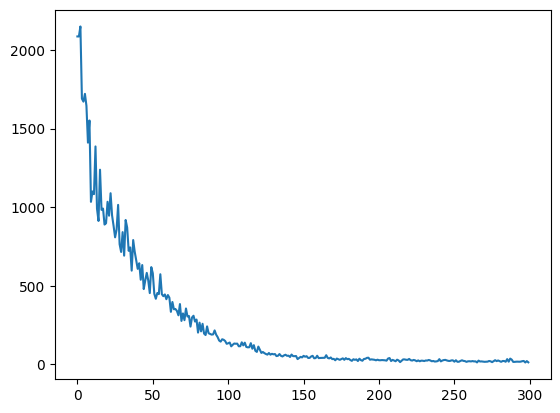

In [6]:
plt.plot(losses)

In [7]:
with torch.no_grad():
    xs = gfn.sample(F_net, n_samples)[..., 0]
    x_trajs = gfn.sample_trajectory(F_net, n_trajs)[..., 0]

(0.0, 51.0)

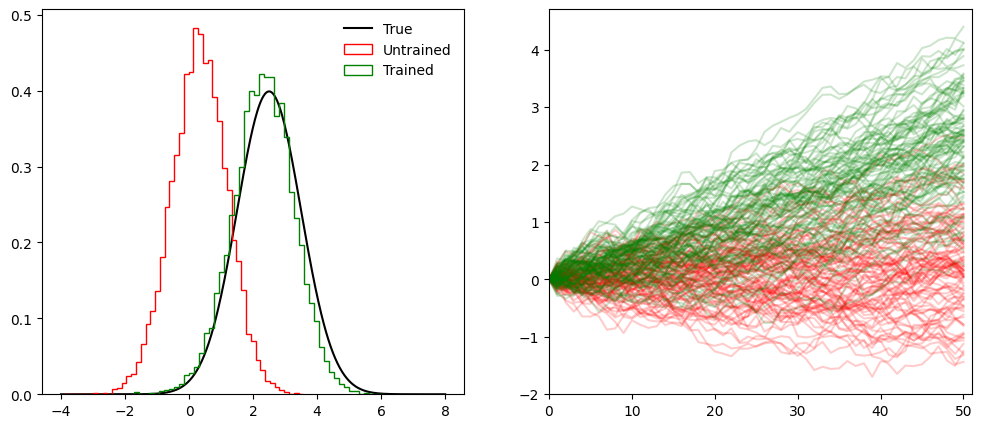

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

ax = axs[0]
ax.plot(x_grid, R_grid, "k", label="True")
ax.hist(
    xs_untrained, density=True, histtype="step", bins=50, label="Untrained", color="r"
)
ax.hist(xs, density=True, histtype="step", bins=50, label="Trained", color="g")
ax.legend(frameon=False)

ax = axs[1]
ax.plot(x_trajs_untrained, c="r", alpha=0.2)
ax.plot(x_trajs, c="g", alpha=0.2)
ax.set_xlim(0, gfn.n_steps + 1)

## Diffusion prior GFlowNet

Set up multimodal prior

In [9]:
weights = torch.tensor([0.15, 0.85])
locs = torch.tensor([[-2.0], [2.0]])
scales = torch.tensor([[0.5], [1.0]])


def sample_x_0(n=(1,)):
    d_i = dist.Categorical(weights)
    i = d_i.sample(n)
    return dist.Normal(locs[i], scales[i]).sample()


def _get_log_prior(x, sigma_t=0.0):
    log_probs = (
        dist.Normal(locs, (scales**2 + sigma_t**2).sqrt(), validate_args=False)
        .to_event(1)
        .log_prob(x[..., None])
    )
    log_probs += weights.log()
    return torch.logsumexp(log_probs, -1)

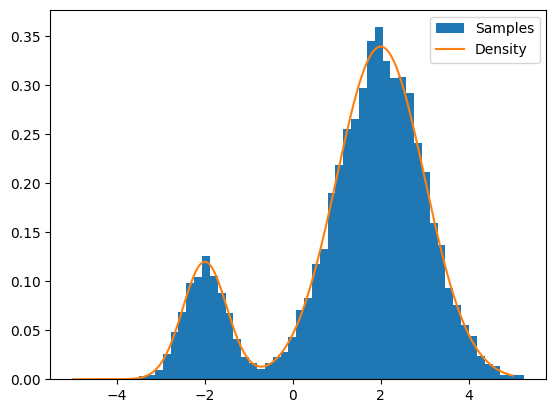

In [10]:
plt.hist(sample_x_0((10_000,)).flatten(), bins=50, density=True, label="Samples")

x_grid = torch.linspace(-5, 5, 500)[:, None]
plt.plot(x_grid, _get_log_prior(x_grid).exp(), label="Density")

plt.legend()

In [11]:
# Set up SDE
T = torch.tensor(1.0)
sigma_min = torch.tensor(1e-2)
# VESDE heuristic: ((x_0s_true.max(0).values - x_0s_true.min(0).values)**2).sum().sqrt()
sigma_max = torch.tensor(10.0)
sde = VESDE(sigma_min, sigma_max, 1, T)

# High-temperature prior
p_T = dist.Normal(torch.tensor([0.0]), sigma_max)

# Set up balancer
get_f = functorch.vmap(sde.drift)
get_g = functorch.vmap(sde.diffusion)
get_log_prior = lambda t, x: _get_log_prior(x, sde.get_sigma(t))
get_score_prior_t = functorch.vmap(functorch.grad(get_log_prior, argnums=1))

# No likelihood
get_log_like_dummy = lambda x: torch.zeros(len(x), device=x.device)

### Sanity check on prior diffusion and denoising process

In [12]:
gfn = NormalDiffPriorGFN(
    get_f, get_g, get_score_prior_t, get_log_like_dummy, T, n_steps=100
)

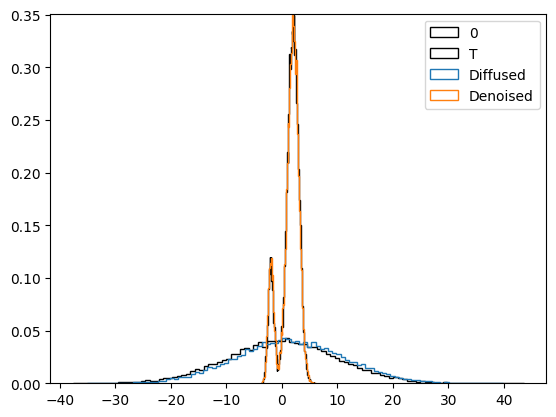

In [13]:
# Diffuse
n = 20_000
x_0s_true = sample_x_0((n,))
x_Ts = gfn.diffuse(x_0s_true)

# Denoise
x_Ts_true = p_T.sample((n,))
x_0s = gfn.denoise(x_Ts)

plt.hist(
    x_0s_true.flatten().numpy(),
    bins=100,
    color="k",
    density=True,
    histtype="step",
    label="0",
)
plt.hist(
    x_Ts_true.flatten().numpy(),
    bins=100,
    color="k",
    density=True,
    histtype="step",
    label="T",
)
plt.hist(
    x_Ts.flatten().numpy(), bins=100, density=True, histtype="step", label="Diffused"
)
plt.hist(
    x_0s.flatten().numpy(), bins=100, density=True, histtype="step", label="Denoised"
)
plt.legend()

### Check: with likelihood set to constant, make sure setting $\tilde{B} = B$ gives prior sampler

In [14]:
class FtNet(nn.Module):
    def __init__(self, get_f, get_g, get_score_prior_t, dt):
        super().__init__()
        self.get_f = get_f
        self.get_g = get_g

    def forward(self, t, x_t):
        f_t = self.get_f(t, x_t)
        g_t = self.get_g(t, x_t)

        mean = x_t + f_t * self.dt
        std = g_t * sqrt(self.dt) * torch.ones_like(x_t)
        return mean, (std**2).log()


class BtNet(nn.Module):
    def __init__(self, get_f, get_g, get_score_prior_t, dt):
        super().__init__()
        self.get_f = get_f
        self.get_g = get_g
        self.get_score_prior_t = get_score_prior_t
        self.dt = dt

    def forward(self, t, x_t):
        f_t = self.get_f(t, x_t)
        g_t = self.get_g(t, x_t)
        score_prior_t = self.get_score_prior_t(t, x_t)
        mean = x_t - (f_t - g_t**2 * score_prior_t) * self.dt
        std = g_t * sqrt(self.dt) * torch.ones_like(x_t)
        return mean, (std**2).log()


class LogZNet(nn.Module):
    def __init__(self, value=0.0):
        super().__init__()
        self.value = nn.Parameter(torch.as_tensor(value), requires_grad=True)

    def __call__(self):
        return self.value

In [15]:
gfn = NormalDiffPriorGFN(
    get_f, get_g, get_score_prior_t, get_log_like_dummy, T, n_steps=100
)

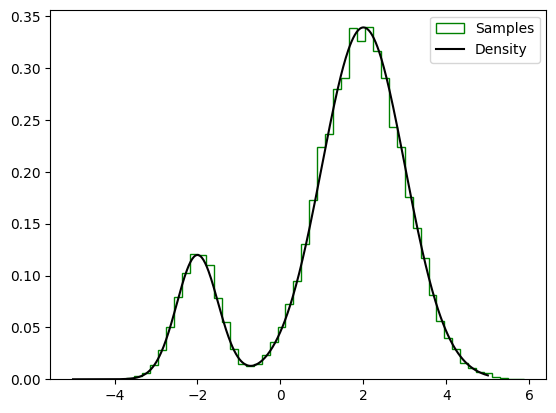

In [16]:
Bt_net = BtNet(get_f, get_g, get_score_prior_t, gfn.dt)
x_Ts = p_T.sample((20_000,))

plt.hist(
    gfn.sample(Bt_net, x_Ts).flatten(),
    bins=50,
    density=True,
    label="Samples",
    color="g",
    histtype="step",
)

x_grid = torch.linspace(-5, 5, 500)[:, None]
plt.plot(x_grid, _get_log_prior(x_grid).exp(), "k", label="Density")

plt.legend()

### Check: with likelihood set to constant, make sure training $\tilde{B}$ learns $B$ (i.e., the prior sampler)

In [17]:
class FtNet(nn.Module):
    def __init__(self, get_f, get_g, dt):
        super().__init__()
        self.get_f = get_f
        self.get_g = get_g
        self.dt = dt

    def forward(self, t, x_t):
        f_t = self.get_f(t, x_t)
        g_t = self.get_g(t, x_t)

        mean = x_t + f_t * self.dt
        std = g_t * sqrt(self.dt) * torch.ones_like(x_t)
        return mean, (std**2).log()


class BtNet(nn.Module):
    def __init__(self, get_f, get_g, get_score_prior_t, dt, x_size, hidden_dim=16):
        super().__init__()
        self.get_f = get_f
        self.get_g = get_g
        self.get_score_prior_t = get_score_prior_t
        self.dt = dt

        self.mlp = nn.Sequential(
            nn.Linear(x_size + 1, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, x_size),
        )

    def forward(self, t, x_t):
        f_t = self.get_f(t, x_t)
        g_t = self.get_g(t, x_t)
        score_prior_t = self.get_score_prior_t(t, x_t)

        assert x_t.ndim == 2
        t = t[:, None]
        emb = torch.cat((t, x_t), 1)
        score_prior_t += 0.5 * self.mlp(emb)

        mean = x_t - (f_t - g_t**2 * score_prior_t) * self.dt
        std = g_t * sqrt(self.dt) * torch.ones_like(x_t)
        return mean, (std**2).log()


class LogZNet(nn.Module):
    def __init__(self, value=0.0):
        super().__init__()
        self.value = nn.Parameter(torch.as_tensor(value), requires_grad=True)

    def __call__(self):
        return self.value

In [18]:
gfn = NormalDiffPriorGFN(
    get_f, get_g, get_score_prior_t, get_log_like_dummy, T, n_steps=100
)

Find seed yielding net that's pretty close to prior to make the problem easy

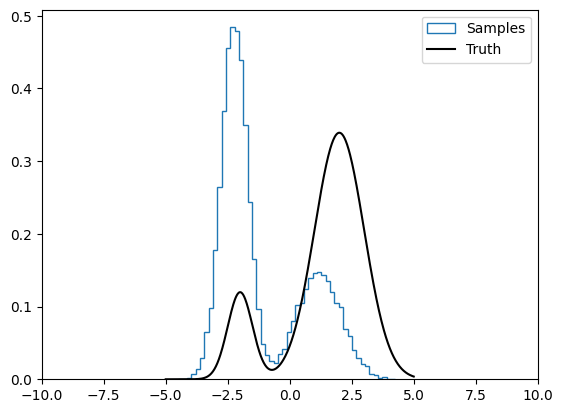

In [19]:
torch.manual_seed(61)

Bt_net = BtNet(get_f, get_g, get_score_prior_t, gfn.dt, 1)
x_Ts = p_T.sample((20_000,))

plt.hist(
    gfn.sample(Bt_net, x_Ts).flatten(),
    bins=50,
    density=True,
    label="Samples",
    histtype="step",
)

x_grid = torch.linspace(-5, 5, 500)[:, None]
plt.plot(x_grid, _get_log_prior(x_grid).exp(), "k", label="Truth")
plt.xlim(-10, 10)

plt.legend()

In [20]:
# torch.manual_seed(61)
torch.manual_seed(63)

Bt_net = BtNet(get_f, get_g, get_score_prior_t, gfn.dt, 1, 8)
Ft_net = FtNet(get_f, get_g, gfn.dt)
log_Z_net = LogZNet()

# Samples from before training
n_samples = 10_000
n_trajs = 200
Bt_net.eval()
with torch.no_grad():
    xs_untrained = gfn.sample(Bt_net, p_T.sample((n_samples,)))
    x_trajs_untrained = gfn.sample_trajectory(Bt_net, p_T.sample((n_trajs,)))

# Only train Bt
Bt_net.train()
optimizer = optim.Adam(Bt_net.parameters(), lr=1e-3)
batch_size = 64
n_steps = 150
losses = []

with trange(n_steps) as pbar:
    for epoch in pbar:
        optimizer.zero_grad()
        x_Ts = p_T.sample((batch_size,))
        loss = gfn.get_loss_tb(Ft_net, Bt_net, log_Z_net, x_Ts).sum()
        # loss = gfn.get_loss_fwd_kl(Ft_net, Bt_net, log_Z_net, x_Ts).sum()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        pbar.set_description(f"loss={losses[-1]:g}")

  0%|          | 0/150 [00:00<?, ?it/s]

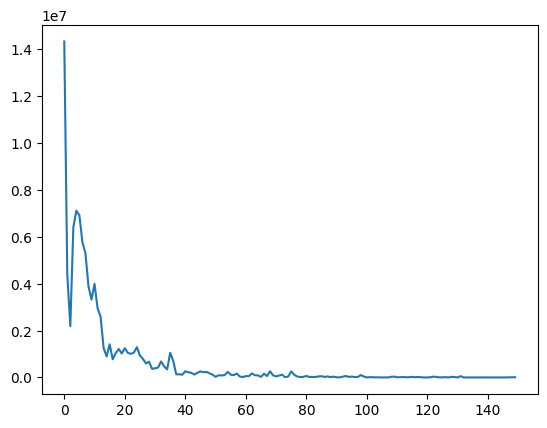

In [21]:
plt.plot(losses)

In [22]:
Bt_net.eval()
with torch.no_grad():
    xs = gfn.sample(Bt_net, p_T.sample((n_samples,)))
    x_trajs = gfn.sample_trajectory(Bt_net, p_T.sample((n_trajs,)))

(-30.0, 30.0)

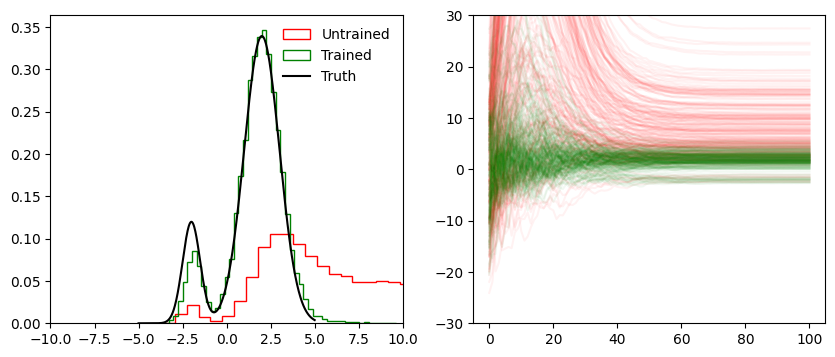

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

ax = axs[0]
ax.hist(
    xs_untrained.flatten(),
    bins=50,
    density=True,
    color="r",
    histtype="step",
    label="Untrained",
)
ax.hist(
    xs.flatten(), bins=50, density=True, color="g", histtype="step", label="Trained"
)
x_grid = torch.linspace(-5, 5, 500)[:, None]
ax.plot(x_grid, _get_log_prior(x_grid).exp(), "k", label="Truth")
ax.set_xlim(-10, 10)
ax.legend(frameon=False)

ax = axs[1]
ax.plot(x_trajs_untrained[:, :, 0], c="r", alpha=0.05)
ax.plot(x_trajs[:, :, 0], c="g", alpha=0.05)
ax.set_ylim(-30, 30)

### Sample multimodal posterior by learning $\tilde{B}$ and $Z = p(y)$

Set up a multimodal likelihood

In [24]:
def _get_log_like(x, y, sigma_t, scale=1.0, omega=2.0, sigma_n=0.5):
    mean = (omega * x).sin()
    std = torch.as_tensor(sigma_n**2 + (scale * sigma_t) ** 2).sqrt()
    return dist.Normal(mean, std, validate_args=False).to_event(1).log_prob(y)


# Specialize and condition
y = torch.tensor([0.0])
get_log_like_t = lambda t, x_t: _get_log_like(x_t, y, sde.get_sigma(t))
get_score_like_t = functorch.vmap(functorch.grad(get_log_like_t, 1))

# Normalized posterior for plotting
x_grid = torch.linspace(-7, 7, 1_000)[:, None]
post_grid = (get_log_prior(0.0, x_grid) + get_log_like_t(0.0, x_grid)).exp()
p_y = post_grid.sum() * (x_grid[1] - x_grid[0])
post_grid /= p_y

Sanity check: make sure likelihood dies out as $t \to T$

(-10.0, 10.0)

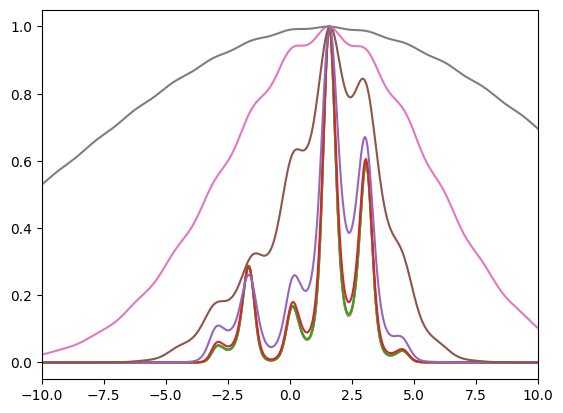

In [25]:
_x_grid = torch.linspace(-50, 50, 2_000)[:, None]

for t in torch.linspace(0, 1, 8)[:, None]:
    _post_grid = (get_log_prior(t, _x_grid) + get_log_like_t(t, _x_grid)).exp()
    _post_grid /= _post_grid.sum() * (_x_grid[1] - _x_grid[0])
    plt.plot(_x_grid, _post_grid / _post_grid.max())

plt.xlim(-10, 10)

In [26]:
class FtNet(nn.Module):
    def __init__(self, get_f, get_g, dt):
        super().__init__()
        self.get_f = get_f
        self.get_g = get_g
        self.dt = dt

    def forward(self, t, x_t):
        f_t = self.get_f(t, x_t)
        g_t = self.get_g(t, x_t)

        mean = x_t + f_t * self.dt
        std = g_t * sqrt(self.dt) * torch.ones_like(x_t)
        return mean, (std**2).log()


class BtNet(nn.Module):
    def __init__(
        self,
        get_f,
        get_g,
        get_score_prior_t,
        get_score_like_t,
        dt,
        x_size,
        hidden_dim=16,
    ):
        super().__init__()
        self.get_f = get_f
        self.get_g = get_g
        self.get_score_prior_t = get_score_prior_t
        self.get_score_like_t = get_score_like_t
        self.dt = dt

        self.mlp = nn.Sequential(
            nn.Linear(x_size + 1, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, x_size),
        )

    def forward(self, t, x_t):
        f_t = self.get_f(t, x_t)
        g_t = self.get_g(t, x_t)
        score_t = self.get_score_prior_t(t, x_t)
        score_t += self.get_score_like_t(t, x_t)

        emb = torch.cat((t[:, None], x_t), 1)
        score_t += 0.3 * self.mlp(emb)

        mean = x_t - (f_t - g_t**2 * score_t) * self.dt
        std = g_t * sqrt(self.dt) * torch.ones_like(x_t)
        return mean, (std**2).log()


class LogZNet(nn.Module):
    def __init__(self, value=0.0):
        super().__init__()
        self.value = nn.Parameter(torch.as_tensor(value), requires_grad=True)

    def __call__(self):
        return self.value

Sanity check: samples before training

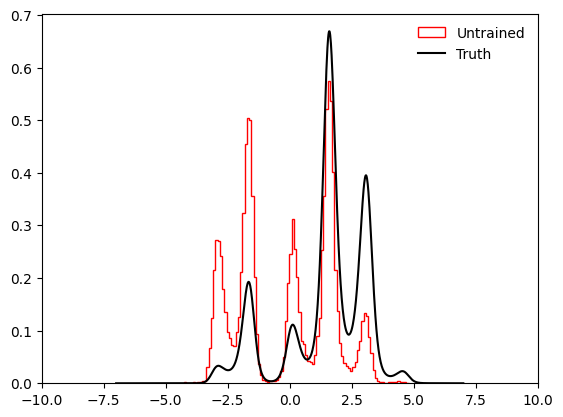

In [27]:
torch.manual_seed(61)

gfn = NormalDiffPriorGFN(
    get_f, get_g, get_score_prior_t, lambda x: get_log_like_t(t, x), T, n_steps=200
)
Bt_net = BtNet(get_f, get_g, get_score_prior_t, get_score_like_t, gfn.dt, 1)
x_Ts = p_T.sample((20_000,))

plt.hist(
    gfn.sample(Bt_net, x_Ts).flatten(),
    bins=100,
    density=True,
    histtype="step",
    color="r",
    label="Untrained",
)

plt.plot(x_grid, post_grid, "k", label="Truth")

plt.xlim(-10, 10)
plt.legend(frameon=False)

In [28]:
# torch.manual_seed(61)
torch.manual_seed(65)

gfn = NormalDiffPriorGFN(
    get_f, get_g, get_score_prior_t, lambda x: get_log_like_t(t, x), T, n_steps=200
)
Bt_net = BtNet(get_f, get_g, get_score_prior_t, get_score_like_t, gfn.dt, 1)
Ft_net = FtNet(get_f, get_g, gfn.dt)
log_Z_net = LogZNet()

# Samples from before training
n_samples = 10_000
n_trajs = 200
Bt_net.eval()
with torch.no_grad():
    xs_untrained = gfn.sample(Bt_net, p_T.sample((n_samples,)))
    x_trajs_untrained = gfn.sample_trajectory(Bt_net, p_T.sample((n_trajs,)))

Bt_net.train()
optimizer = optim.Adam(
    list(Bt_net.parameters()) + list(log_Z_net.parameters()), lr=1e-3
)
batch_size = 64
n_steps = 150
losses = []

with trange(n_steps) as pbar:
    for epoch in pbar:
        optimizer.zero_grad()
        x_Ts = p_T.sample((batch_size,))
        loss = gfn.get_loss_tb(Ft_net, Bt_net, log_Z_net, x_Ts).sum()
        # loss = gfn.get_loss_fwd_kl(Ft_net, Bt_net, log_Z_net, x_Ts).sum()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        pbar.set_description(f"loss={losses[-1]:g}")

  0%|          | 0/150 [00:00<?, ?it/s]

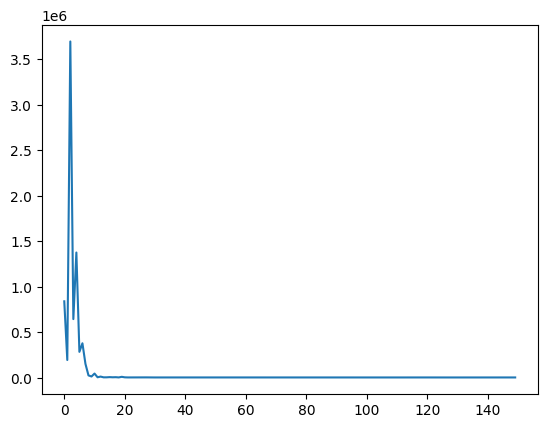

In [29]:
plt.plot(losses)

In [30]:
Bt_net.eval()
with torch.no_grad():
    xs = gfn.sample(Bt_net, p_T.sample((n_samples,)))
    x_trajs = gfn.sample_trajectory(Bt_net, p_T.sample((n_trajs,)))

(-30.0, 30.0)

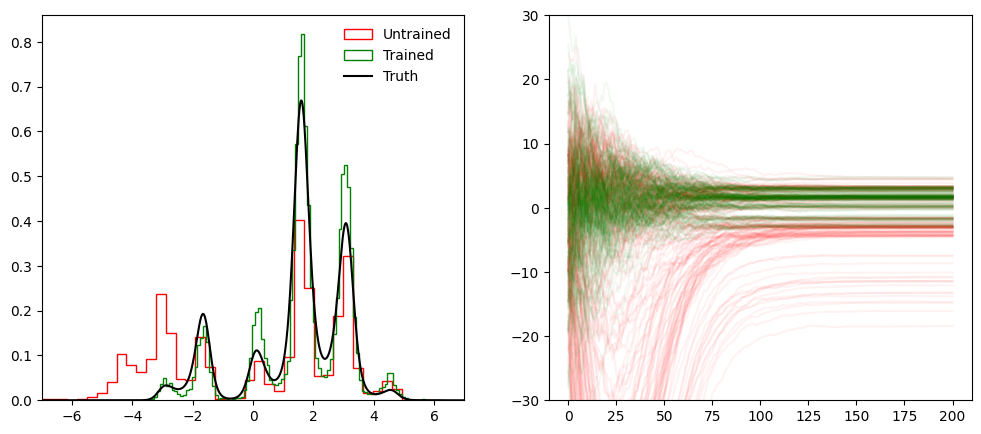

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

ax = axs[0]
ax.hist(
    xs_untrained.flatten(),
    bins=100,
    density=True,
    color="r",
    histtype="step",
    label="Untrained",
)
ax.hist(
    xs.flatten(), bins=100, density=True, color="g", histtype="step", label="Trained"
)
ax.plot(x_grid, post_grid, "k", label="Truth")
ax.set_xlim(-7, 7)
ax.legend(frameon=False)

ax = axs[1]
ax.plot(x_trajs_untrained[:, :, 0], c="r", alpha=0.05)
ax.plot(x_trajs[:, :, 0], c="g", alpha=0.05)
ax.set_ylim(-30, 30)